In [8]:
import sys
sys.path.append('..')

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from CommonFunctions import enhance_plot, set_polygon_color
%matplotlib inline

In [10]:
class AutoRegressiveModel:
    def __init__(self, 
                 coefficients: list[float:],
                 constant: float = 0):
        self.coefficients = np.array(coefficients)
        self.order = len(coefficients)
        self.constant = constant
    
    def __str__(self):
        coeffs = [f'{theta}y_{r"{"}t-{i+1}{r"}"}' 
                  for i, theta in enumerate(self.coefficients)
                  if theta != 0]
        coeffs = ' + '.join(coeffs)
        return f'$y_t ={f" {self.constant} +" if self.constant != 0 else ""} {coeffs} + \epsilon_t$'
    
    def __call__(self, n: int, time_series: np.array = None, burn_in: int = 0):
        return self._fit(n, time_series=time_series, burn_in=burn_in)
    
    def _fit(self, n: int, time_series: np.array = None, burn_in: int = 0):
        pred_len = self.order + n + burn_in
        prediction = np.zeros(pred_len)
        noise = np.random.normal(loc=0, scale=1, size=pred_len)
        if time_series is None:
            prediction[:self.order] = noise[:self.order]
        else:
            prediction[:self.order] = time_series[::-1][:self.order]
        for t in range(self.order, pred_len):
            prediction[t] = (np.sum(prediction[t - self.order:t][::-1] * self.coefficients) 
                             + self.constant + noise[t])
        # we discard initial elements + burn_in parameter
        return prediction[self.order + burn_in:]

In [11]:
n = 5000
constant = 18
lags = 50
theta_params_list = [[theta] for theta in [-0.6, -0.7, -0.8, -0.9][::-1]]
time_series_list = []
model_list = []
for theta_params in theta_params_list:
    model = AutoRegressiveModel(theta_params, constant)
    time_series_list.append(model(n))
    model_list.append(model)

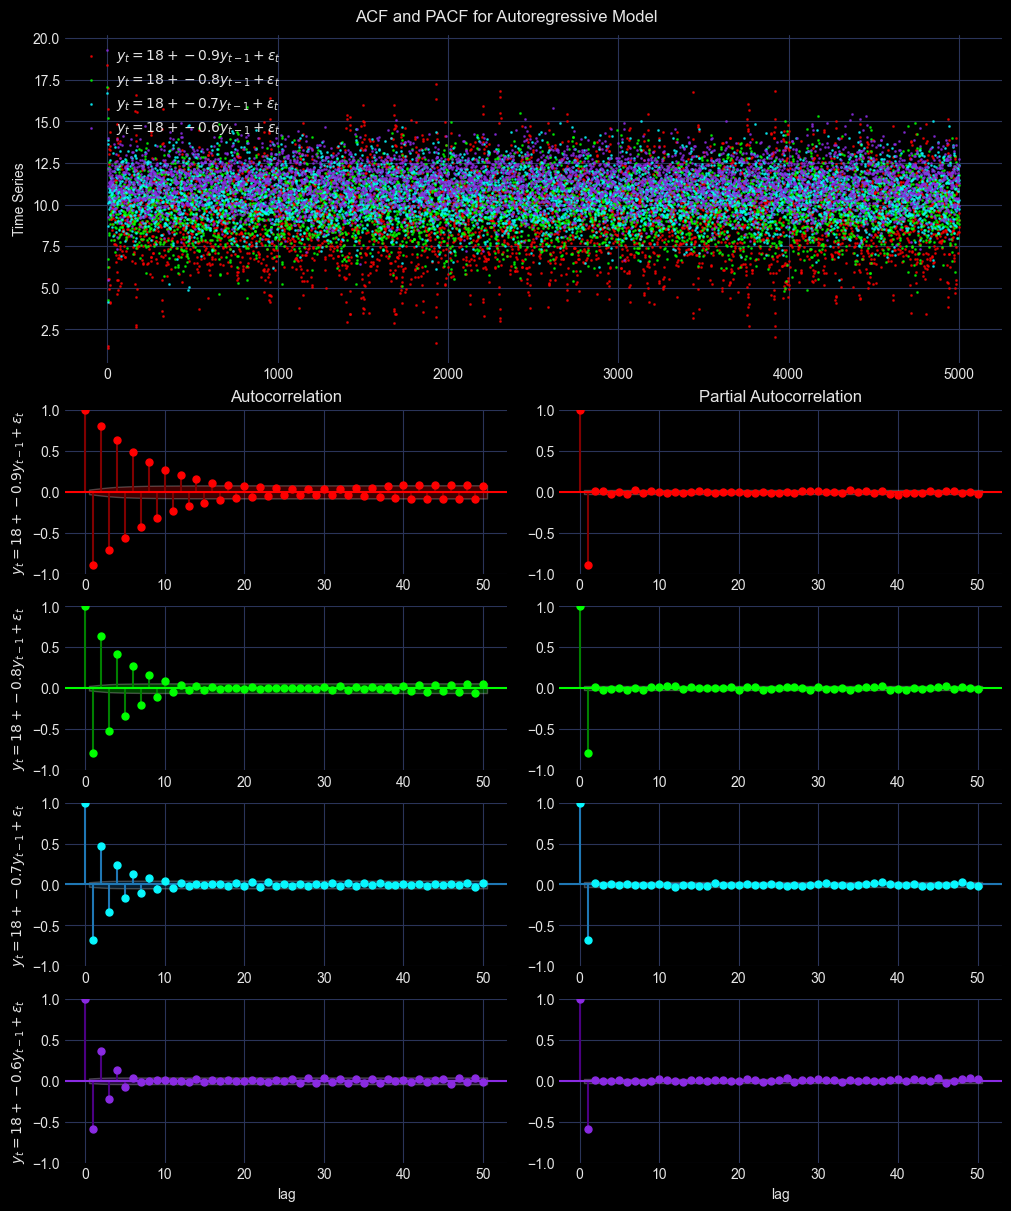

In [12]:
def plot_time_series_analysis(size, alpha, file): 
    colors = ['red', 'lime', None, 'blueviolet']
    bg_colors = ['maroon', 'green', None, 'indigo']
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplot_mosaic(
            [['time', 'time'], *[[f'acf-{theta}', f'pacf-{theta}'] for theta in theta_params_list]],
            layout='constrained', figsize=size, 
            height_ratios=[2, *[1 for _ in range(len(time_series_list))]])
        for index, (theta_params, time_series, model) in (
                enumerate(zip(theta_params_list, time_series_list, model_list))):
            num_of_series = len(time_series_list)
            time_domain = range(1, len(time_series) + 1)
            axes['time'].scatter(time_domain, time_series, s=1,
                                 label=str(model), alpha=alpha,
                                 color=colors[index])
            axes['time'].legend()
            plot_acf(time_series, ax=axes[f'acf-{theta_params}'], lags=lags, title=None,
                     color=colors[index], vlines_kwargs=dict(color=bg_colors[index]))
            set_polygon_color(axes[f'acf-{theta_params}'], colors[index])
            plot_pacf(time_series, ax=axes[f'pacf-{theta_params}'], lags=lags, title=None,
                      color=colors[index],vlines_kwargs=dict(color=bg_colors[index]))
            set_polygon_color(axes[f'pacf-{theta_params}'], colors[index])
            axes[f'acf-{theta_params}'].set(ylabel=str(model))
            axes['time'].set(ylabel='Time Series')
            if index == num_of_series - 1:
                axes[f'acf-{theta_params}'].set(xlabel='lag')
                axes[f'pacf-{theta_params}'].set(xlabel='lag')
            if index == 0:
                axes[f'acf-{theta_params}'].set(title='Autocorrelation')
                axes[f'pacf-{theta_params}'].set(title='Partial Autocorrelation')
            enhance_plot(figure, axes[f'acf-{theta_params}'])
            enhance_plot(figure, axes[f'pacf-{theta_params}'])
        figure.suptitle(f'ACF and PACF for Autoregressive Model')
        enhance_plot(figure, axes=axes['time'])
    figure.savefig(file)
plot_time_series_analysis((10, 12), 0.7, 'images/ARfig1.png')

We can see that partial correlation function correctly captures model coefficients.

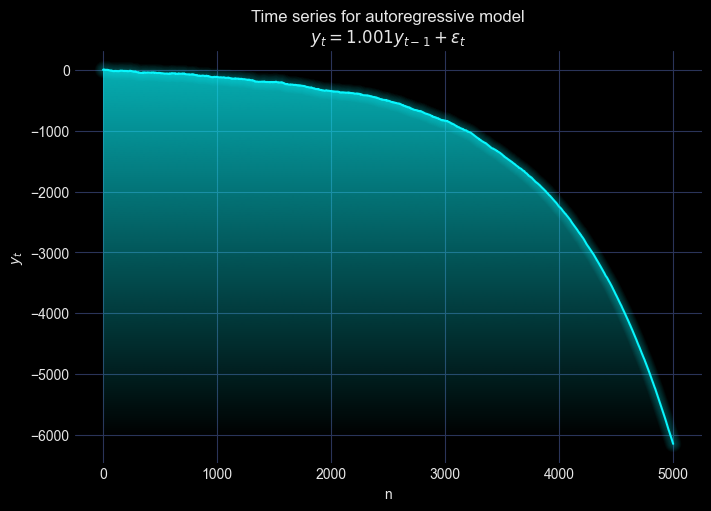

In [13]:
model1 = AutoRegressiveModel([1.001], 0)
time_series = model1(n)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
    axes.plot(range(1, len(time_series) + 1), time_series)
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.7)
    axes.set(xlabel='n', ylabel='$y_t$', 
             title=f'Time series for autoregressive model\n{str(model1)}')
figure.savefig('images/ARfig2.png')

We can see that for params higher than 1 time series doesn't converge.

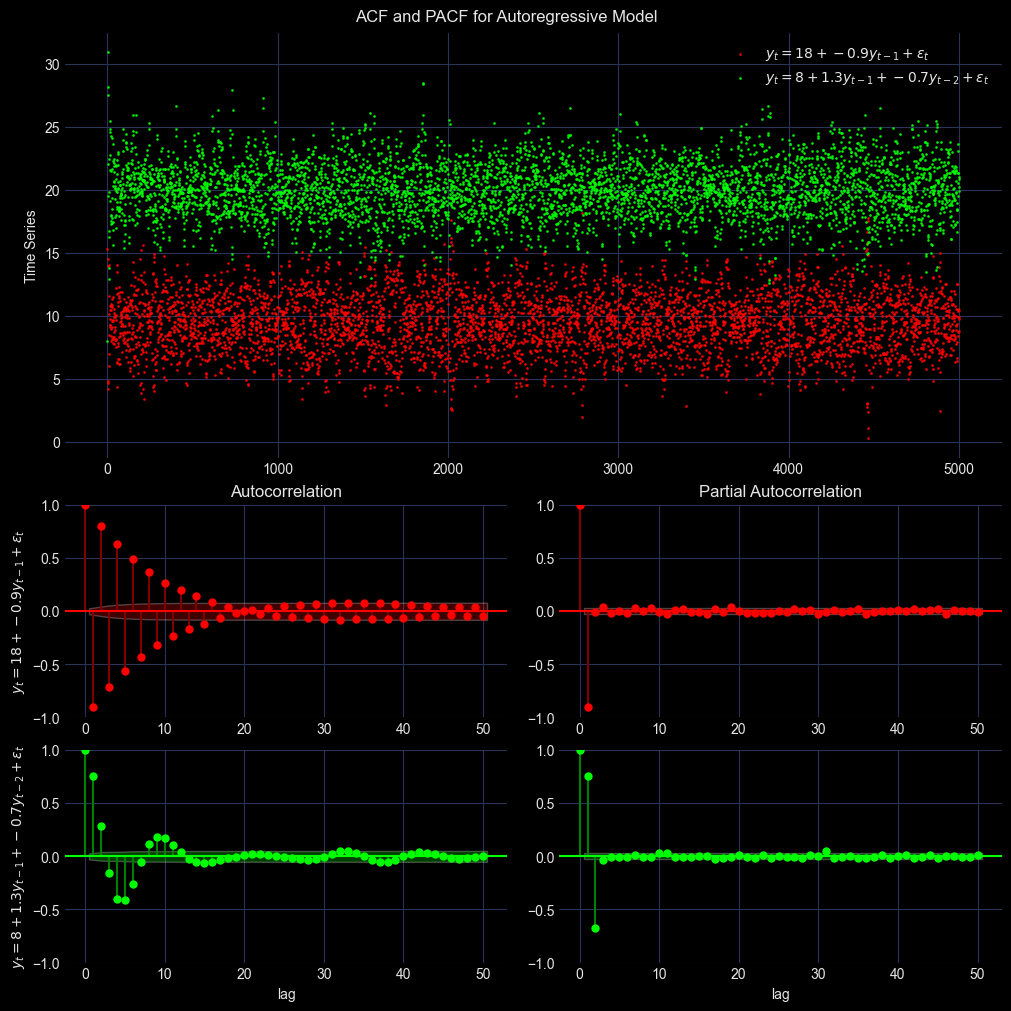

In [14]:
n = 5000
lags = 50
theta_params_list = [[-0.9], [1.3, -0.7]]
constants = [18, 8]
time_series_list = []
model_list = []
for theta_params, c in zip(theta_params_list, constants):
    model = AutoRegressiveModel(theta_params, c)
    time_series_list.append(model(n))
    model_list.append(model)
plot_time_series_analysis((10, 10), 0.8, 'images/ARfig3.png')

We see that more parameters are observed in PACF function.